## Imports

In [138]:
import numpy as np
np.seterr(all='ignore')
import os, os.path
import pydicom
import cv2
import math
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.signal
import statistics
from itertools import *

## Functions

### `dcm_reader`

In [139]:
def dcm_reader(dcm_path):
    #read dcm_files from path
    #path certainly contains DCM files, as tested by dcm_list_builder function
    dcm_files = []
    for (dirpath, dirnames, filenames) in os.walk(dcm_path,topdown=False):
        for filename in filenames:
            try:
                if not filename == 'DIRFILE':   
                    dcm_file = str(os.path.join(dirpath, filename))
                    pydicom.read_file(dcm_file, stop_before_pixels = True)
                    dcm_files.append(dcm_file)
            except:
                pass

    read_RefDs = True
    while read_RefDs:
        for index in range(len(dcm_files)):
            try:
                RefDs = pydicom.read_file(dcm_files[index], stop_before_pixels = False)
                read_RefDs = False
                break
            except:
                pass
    
    slice_thick_ori = RefDs.SliceThickness
    
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(dcm_files))
    dcm_array = np.zeros([ConstPixelDims[0],ConstPixelDims[1],len(dcm_files)],\
                          dtype=RefDs.pixel_array.dtype) 

    instances = []    
    for filenameDCM in dcm_files:
        try:
            ds = pydicom.read_file(filenameDCM, stop_before_pixels = True)
            instances.append(int(ds.InstanceNumber))
        except:
            pass
    
    instances.sort()

    index = 0
    for filenameDCM in dcm_files:
        try:
            ds = pydicom.read_file(filenameDCM)
            dcm_array[:,:,instances.index(ds.InstanceNumber)] = ds.pixel_array
            if ds.InstanceNumber in instances[:2]:
                if ds.InstanceNumber == instances[0]:
                    loc_1 = ds.SliceLocation
                else:
                    loc_2 = ds.SliceLocation
            index += 1
        except:
            pass
        
    try:
        RefDs.SliceThickness = abs(loc_1 - loc_2)
    except:
        pass
        
        
    dcm_array = dcm_array * RefDs.RescaleSlope + RefDs.RescaleIntercept
    return RefDs, dcm_array, slice_thick_ori

In [140]:
tst_path = "/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/"

In [141]:
dcm_reader(tst_path)

(Dataset.file_meta -------------------------------
 (0002, 0000) File Meta Information Group Length  UL: 190
 (0002, 0001) File Meta Information Version       OB: b'\x00\x01'
 (0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
 (0002, 0003) Media Storage SOP Instance UID      UI: 1.2.392.200036.9116.2.6.1.3268.2051117512.1455185286.537752
 (0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
 (0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
 (0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
 -------------------------------------------------
 (0008, 0000) Group Length                        UL: 476
 (0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
 (0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'MPR']
 (0008, 0016) SOP Class UID                       UI: CT Image Storage
 (0008, 0018) SOP Instance UID                    UI: 1.2.392.200036.9116.2.6.1.3268.2

### `dcm_list_builder`

In [142]:
def dcm_list_builder(path, test_text = ""):
    # function to get list of dcm_files from dcm directory
    dcm_path_list = []
    for (dirpath, dirnames, filenames) in os.walk(path, topdown=True):
        if dirpath not in dcm_path_list:
            for filename in filenames:
                try:
                    tmp_str = str(os.path.join(dirpath, filename))
                    ds = pydicom.read_file(tmp_str, stop_before_pixels = True)
                    if dirpath not in dcm_path_list:
                        dcm_path_list.append(dirpath)
                except:
                    pass
            else:
                pass
    return dcm_path_list

In [143]:
dcm_list_builder(tst_path)

['/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep1',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep1',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep3',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep4',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep5',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep2',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep4',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep3',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep2',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep5']

In [144]:
def findCircle(point_1, point_2, point_3): 
    x1, y1 = point_1
    x2, y2 = point_2
    x3, y3 = point_3
    
    x12 = x1 - x2 
    x13 = x1 - x3  
    y12 = y1 - y2  
    y13 = y1 - y3 
    y31 = y3 - y1  
    y21 = y2 - y1
    x31 = x3 - x1  
    x21 = x2 - x1 
 
    sx13 = x1**2 - x3**2  
    sy13 = y1**2 - y3**2
    sx21 = x2**2 - x1**2  
    sy21 = y2**2 - y1**2  
  
    f = (((sx13) * (x12) + (sy13) * (x12) + (sx21) * (x13) +\
          (sy21) * (x13)) // (2 * ((y31) * (x12) - (y21) * (x13)))) 
              
    g = (((sx13) * (y12) + (sy13) * (y12) + (sx21) * (y13) + (sy21) *\
          (y13)) // (2 * ((x31) * (y12) - (x21) * (y13))))  
  
    # eqn of circle be x^2 + y^2 + 2*g*x + 2*f*y + c = 0 where centre is (h = -g, k = -f)  
    center_insert = [-g,-f]

    return center_insert

In [145]:
findCircle([309, 309], [312, 200], [155, 155])

[213, 252]

### `dcm_masked`

In [146]:
def dcm_masked(array_used = None, radius_val = 95, slice_used_center = None):
    try:
        pixel_size = header.PixelSpacing[0]
    except:
        FOV = header.ReconstructionDiameter
        matrix_size = header.Rows
    
        pixel_size = FOV / matrix_size
    
    radius = (radius_val/2) / pixel_size
    
    central_image = array_used[:,:,slice_used_center].copy()
    
    central_image[central_image > -200] = 0
    central_image[central_image != 0] = 1

    image_kernel = math.ceil(5 / header.PixelSpacing[0])
    if image_kernel % 2 == 0:
        image_kernel += 1
    central_image = scipy.signal.medfilt2d(central_image, image_kernel)
    
    # print(central_image)
    # plt.imshow(central_image, cmap='bone')
    # plt.show()

    center = [int(array_used.shape[0] / 2), int(array_used.shape[1] / 2)]
    
    a = central_image.copy()
    for index in range(int(array_used.shape[1] / 2)):
        # print(central_image[center[0] + index, center[1] + index])
        if (central_image[center[0] + index, center[1] + index] == 1 and\
            central_image[center[0] + index, center[1] + index + 5] == 1):
            point_1 = [center[0] + index, center[1] + index]
            break
        else:
            a[center[0] + index, center[1] + index] = 2
            pass
    
    for index in range(int(array_used.shape[1] / 2)):
        if (central_image[center[0] + index, center[1] - index] == 1 and\
            central_image[center[0] + index, center[1] - index - 5] == 1):
            point_2 = [center[0] + index, center[1] - index]
            break
        else:
            a[center[0] + index, center[1] - index] = 2
            pass
        
    # x_iter = range(center[0], int(array_used.shape[0]), 1)
    # y_iter = range(center[1], int(array_used.shape[1]), 2)
    # for tmp_x, tmp_y in zip(x_iter, y_iter):
    #     if (central_image[tmp_x, tmp_y] == 1 and central_image[tmp_x + 5, tmp_y + 5] == 1):
    #         point_3 = [tmp_x, tmp_y]
    #         break
    #     else:
    #         a[tmp_x, tmp_y] = 2
    #         pass
        
        
    for index in range(int(array_used.shape[1] / 2)):
        if (central_image[center[0] - index, center[1] - index] == 1 and\
            central_image[center[0] - index, center[1] - index - 5] == 1):
            point_3 = [center[0] - index, center[1] - index]
            break
        else:
            a[center[0] - index, center[1] - index] = 2
            pass
        
    # plt.imshow(a)
    # plt.show()
    # print(point_1, point_2, point_3)
    center_insert = findCircle(point_1, point_2, point_3)

    Y, X = np.ogrid[:header.Rows, :header.Columns]
    dist_from_center = np.sqrt((X - center_insert[1])**2 + (Y-center_insert[0])**2)

    mask = dist_from_center <= radius  
    masked_array = np.zeros_like(array_used)
    for index in range(array_used.shape[2]):
        masked_array[:,:,index] = array_used[:,:,index] * mask

    return masked_array, center_insert, mask

### CCI_calcium_image

In [183]:
def CCI_calcium_image(calcium_threshold=130, comp_connect=4):
    # threshold array according to calcium_threshold 
    # simultaneously make image binary
    array = dcm_array.copy()
    array[array < 1.1*calcium_threshold] = 0
    array[array > 0] = 1
    array = array.astype(dtype = np.uint8)
    
    CCI_5mm_num_pixels = int(math.pi * (5/2)**2 / header.PixelSpacing[0]**2)
    cal_rod_num_pixels = int(math.pi * (20/2)**2 / header.PixelSpacing[0]**2)

    image_kernel = math.ceil(5 / header.PixelSpacing[0])
    if image_kernel % 2 == 0:
        image_kernel += 1
        
    # plt.imshow(array[:,:,20], cmap='bone')
    # plt.xticks(fontsize = 35)
    # plt.yticks(fontsize = 35)
    # plt.show()
    
    slice_dict =  {}
    large_index = []
    cal_rod_dict = {}
    for idx in range(array.shape[2]):
        print("idx: ", idx)
        array_filtered = scipy.signal.medfilt2d(array[:,:,idx], image_kernel)
        output = cv2.connectedComponentsWithStats(array_filtered, comp_connect, cv2.CV_32S)
        count_5mm = 0
        for index in range(1,output[0]):
            print("index:", index)
            print("output[2][index][4] AREA?: ", output[2][index][4])
            print("output[3][index][1] CENTER-Y: ", int(output[3][index][1]))
            print("output[3][index][0] CENTER-X: ", int(output[3][index][0]))
            if output[2][index][4] in range(int(CCI_5mm_num_pixels * 0.6),\
                     int(CCI_5mm_num_pixels * 1.5)):
                count_5mm += 1
            elif output[2][index][4] in range(int(cal_rod_num_pixels * 0.7),\
                     int(cal_rod_num_pixels * 1.3)):
                cal_rod_dict[index] = [int(output[3][index][1]), int(output[3][index][0])]
        if (count_5mm > 0 and count_5mm < 4):
            slice_dict[idx] = count_5mm
    
        poppable_keys = []
        for key in cal_rod_dict.keys():
            start_coordinate = [cal_rod_dict[key][0], cal_rod_dict[key][1]]
            
            x_right = 0
            while array_filtered[start_coordinate[0], start_coordinate[1] + x_right] == 1:
                x_right += 1
            
            x_left = 0
            while array_filtered[start_coordinate[0], start_coordinate[1] - x_left] == 1:
                x_left += 1
            
            y_top = 0
            while array_filtered[start_coordinate[0] + y_top, start_coordinate[1]] == 1:
                y_top += 1
            
            y_bottom = 0
            while array_filtered[start_coordinate[0] - y_bottom, start_coordinate[1]] == 1:
                y_bottom += 1
                
            x_dist = x_right + x_left
            y_dist = y_top + y_bottom
            
            if x_dist not in range(int(0.7*y_dist), int(1.2*y_dist)):
                poppable_keys.append(key)
            else:
                pass
            
        for key in poppable_keys:
                cal_rod_dict.pop(key)
                
        if len(cal_rod_dict) == 0:
            pass
        else:
            large_index.append(idx)
    # flipped_index = np.where(dcm_array[center[0], center[1], :] == max(dcm_array[center[0], center[1], :]))[0][0]
    flipped_index = int(statistics.median(large_index))

    edge_index = []
    if flipped_index < (dcm_array.shape[2] / 2):
        flipped = -1
        for element in large_index:
            if element > (dcm_array.shape[2] / 2):
                edge_index.append(element)
        if not edge_index:
            pass
        else:
            for index_edge in range(min(edge_index), dcm_array.shape[2]):
                try:
                    del(slice_dict[index_edge])
                except:
                    pass
            for element2 in edge_index:
                large_index.remove(element2)
                
        for element in range(max(large_index)):
            try:
                del(slice_dict[element])
            except:
                pass        
    else:
        flipped = 1
        for element in large_index:
            if element < (dcm_array.shape[2] / 2):
                edge_index.append(element)
        if not edge_index:
            pass
        else:
            for index_edge in range(max(edge_index)):
                try:
                    del(slice_dict[index_edge])
                except:
                    pass
            for element2 in edge_index:
                large_index.remove(element2)
        for element in range(min(large_index), dcm_array.shape[2]):
            try:
                del(slice_dict[element])
            except:
                pass
    
    poppable_keys = []        
    if flipped == -1:
        for key in slice_dict.keys():
            if key > (flipped_index + (55 / header.SliceThickness)):
                poppable_keys.append(key)
    elif flipped == 1:
        for key in slice_dict.keys():
            if key < (flipped_index - (55 / header.SliceThickness)):
                poppable_keys.append(key)
    for key in poppable_keys:
                slice_dict.pop(key)            
                
       
    max_key, _ = max(zip(slice_dict.values(), slice_dict.keys()))

    max_keys = []
    for key in slice_dict.keys():
        if slice_dict[key] is max_key:
            max_keys.append(key)
    
    slice_CCI = int(statistics.median(max_keys))
    
    array = dcm_array.copy()
    array[array < calcium_threshold] = 0
    array[array > 0] = 1
    array = array.astype(dtype = np.uint8)
    
    calcium_image = array * dcm_array
    quality_slice = round(slice_CCI - flipped * (20 / header.SliceThickness))

    cal_rod_slice = slice_CCI + (flipped * int(30 / header.SliceThickness))
    
    return calcium_image, slice_CCI, quality_slice, cal_rod_slice, flipped, output

In [148]:
def calc_centers(output, tmp_center, CCI_array):
    sizes = []
    for size_index in range(1,len(output[2])):
        sizes.append(output[2][size_index][4])

    largest = {}
    for index in range(1,len(output[3])):
        dist_loc = math.sqrt((tmp_center[1] - output[3][index][0])**2 +\
                             (tmp_center[0] - output[3][index][1])**2)
        dist_loc *= header.PixelSpacing[0]
        if dist_loc > 31:
            largest[index] = [int(output[3][index][1]),int(output[3][index][0])]
        else:
            pass

    max_dict = {}
    for key in largest.keys():
        tmp_arr = create_circular_mask(header.Rows, header.Columns,\
                                       [largest[key][1],largest[key][0]],\
                                       math.ceil(2.5 / header.PixelSpacing[0]))
        tmp_arr = tmp_arr * dcm_array[:,:,CCI_slice] +\
                    tmp_arr * dcm_array[:,:,CCI_slice - 1] +\
                    tmp_arr * dcm_array[:,:,CCI_slice + 1]
        tmp_arr[tmp_arr == 0] = np.nan
        max_dict[key] = np.nanmedian(tmp_arr)

    large1_index, large1_key = max(zip(max_dict.values(), max_dict.keys()))
    max_dict.pop(large1_key)
    large2_index, large2_key = max(zip(max_dict.values(), max_dict.keys()))
    max_dict.pop(large2_key)
    large3_index, large3_key = max(zip(max_dict.values(), max_dict.keys()))

    center1 = largest[large1_key]
    center2 = largest[large2_key]  
    center3 = largest[large3_key]       

    global center
    center = findCircle(center1, center2, center3)
    
    
    centers = {}
    for size_index4 in (center1, center2, center3):
        center_index = size_index4
        side_x = abs(center[0]-center_index[0])
        side_y = abs(center[1]-center_index[1])
        
        angle = angle_calc(side_x, side_y)
        if (center_index[0] < center[0] and center_index[1] < center[1]):
                medium_calc = [int(center_index[0] + (12.5 / header.PixelSpacing[0]) * math.sin(angle)),\
                               int((center_index[1] + (12.5 / header.PixelSpacing[1]) * math.cos(angle)))]
            
                low_calc = [int(center_index[0] + (25 / header.PixelSpacing[0]) * math.sin(angle)),\
                            int((center_index[1] + (25 / header.PixelSpacing[1]) * math.cos(angle)))]
        elif (center_index[0] < center[0] and center_index[1] > center[1]):
                medium_calc = [int(center_index[0] + (12.5 / header.PixelSpacing[0]) * math.sin(angle)),\
                               int((center_index[1] - (12.5 / header.PixelSpacing[1]) * math.cos(angle)))]
            
                low_calc = [int(center_index[0] + (25 / header.PixelSpacing[0]) * math.sin(angle)),\
                            int((center_index[1] - (25 / header.PixelSpacing[1]) * math.cos(angle)))] 
        elif (center_index[0] > center[0] and center_index[1] < center[1]):
                medium_calc = [int(center_index[0] - (12.5 / header.PixelSpacing[0]) * math.sin(angle)),\
                               int((center_index[1] + (12.5 / header.PixelSpacing[1]) * math.cos(angle)))]
            
                low_calc = [int(center_index[0] - (25 / header.PixelSpacing[0]) * math.sin(angle)),\
                            int((center_index[1] + (25 / header.PixelSpacing[1]) * math.cos(angle)))]
        elif (center_index[0] > center[0] and center_index[1] > center[1]):
                medium_calc = [int(center_index[0] - (12.5 / header.PixelSpacing[0]) * math.sin(angle)),\
                               int((center_index[1] - (12.5 / header.PixelSpacing[1]) * math.cos(angle)))]
            
                low_calc = [int(center_index[0] - (25 / header.PixelSpacing[0]) * math.sin(angle)),\
                            int((center_index[1] - (25 / header.PixelSpacing[1]) * math.cos(angle)))]
        elif (side_x == 0 and center_index[1] < center[1]):
                medium_calc = [int(center_index[0]), int(center_index[1] + (12.5 / header.PixelSpacing[1]))]
            
                low_calc = [int(center_index[0]), int(center_index[1] + (25 / header.PixelSpacing[1]))]
        elif (side_x == 0 and center_index[1] > center[1]):
                medium_calc = [int(center_index[0]), int(center_index[1] - (12.5 / header.PixelSpacing[1]))]
            
                low_calc = [int(center_index[0]), int(center_index[1] - (25 / header.PixelSpacing[1]))]
        elif (center_index[0] > center[0] and side_y == 0):
                medium_calc = [int(center_index[0] - (12.5 / header.PixelSpacing[0])), int(center_index[1])]
            
                low_calc = [int(center_index[0] - (25 / header.PixelSpacing[0])), int(center_index[1])]
        elif (center_index[0] > center[0] and side_y == 0):
                medium_calc = [int(center_index[0] + (12.5 / header.PixelSpacing[0])), int(center_index[1])]
            
                low_calc = [int(center_index[0] + (25 / header.PixelSpacing[0])), int(center_index[1])]
        else:
                print("unknown angle.. error!")
                
        if size_index4 == center1:
            centers['Large_HD'] = ([center_index])
            centers['Medium_HD'] = ([medium_calc])
            centers['Small_HD'] = ([low_calc])            
        
        elif size_index4 == center2:
            centers['Large_MD'] = ([center_index])
            centers['Medium_MD'] = ([medium_calc])
            centers['Small_MD'] = ([low_calc])    
        
        elif size_index4 == center3:
            centers['Large_LD'] = ([center_index])
            centers['Medium_LD'] = ([medium_calc])
            centers['Small_LD'] = ([low_calc])   
        
        else:
            pass
    
    return centers

In [149]:
def angle_calc(side1, side2):
    #Calculate angle between two sides of rectangular triangle
    if side1 == 0:
        angle = 0
    elif side2 == 0:
        angle = math.pi / 2
    else:
        angle = math.atan(side1 / side2)
    
    return angle

In [150]:
def create_circular_mask(h, w, center_circle, radius_circle):

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center_circle[0])**2 + (Y-center_circle[1])**2)

    mask = dist_from_center <= radius_circle
    
    return mask

In [151]:
def mask_inserts(print_plot = False):
    # Actual scoring for CCI insert
    # First step is to remove slices without calcium from arrays            
    CCI_min = int((CCI_slice - math.ceil(5 / header.SliceThickness)) - 1)
    CCI_max = int((CCI_slice + math.ceil(5 / header.SliceThickness)) + 1)
    central_CCI = int((CCI_max - CCI_min)/2)
    
    if CCI_min < 0:
        CCI_min = 0
    if CCI_max > dcm_array.shape[2]:
        CCI_max = dcm_array.shape[2]
    
    CCI_array = dcm_array[:,:,CCI_min:CCI_max].copy()
    
    CCI_array_binary = CCI_array.copy()
    CCI_array_binary[CCI_array_binary < 1.0*calcium_threshold] = 0
    CCI_array_binary[CCI_array_binary > 0] = 1
    CCI_array_binary = CCI_array_binary.astype(dtype = np.uint8)
    
    _, _, _, centroids = cv2.connectedComponentsWithStats(CCI_array_binary[:,:,central_CCI - 1] +\
                                                          CCI_array_binary[:,:,central_CCI] +\
                                                          CCI_array_binary[:,:,central_CCI + 1],\
                                                          comp_connect,cv2.CV_32S)
    
    centroids = np.delete(centroids,0,0)
    

    image_kernel = math.ceil(3 / header.PixelSpacing[0])
    if image_kernel % 2 == 0:
        image_kernel += 1
        
    image_for_center = scipy.signal.medfilt2d(CCI_array_binary[:,:,central_CCI - 1], image_kernel) +\
                       scipy.signal.medfilt2d(CCI_array_binary[:,:,central_CCI], image_kernel) +\
                       scipy.signal.medfilt2d(CCI_array_binary[:,:,central_CCI + 1], image_kernel)
                       
    if print_plot:
        plt.imshow(image_for_center)
        plt.show()
        plt.imshow(image_for_center, cmap='bone')
        plt.xticks(fontsize = 10)
        plt.yticks(fontsize = 10)
        plt.show()
    
    output = cv2.connectedComponentsWithStats(image_for_center, comp_connect,cv2.CV_32S)

    tmp_center = center.copy()
    calc_size_density_VS_AS_MS = calc_centers(output, tmp_center, CCI_array)
        
    for key in calc_size_density_VS_AS_MS.keys():
        calc_size_density_VS_AS_MS[key].append(0)
        calc_size_density_VS_AS_MS[key].append(0)
        calc_size_density_VS_AS_MS[key].append(0)
    
    mask_L_HD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Large_HD'][0][1],\
                       calc_size_density_VS_AS_MS['Large_HD'][0][0]],math.ceil((5 / header.PixelSpacing[0])/2) + 1)
    mask_L_MD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Large_MD'][0][1],\
                       calc_size_density_VS_AS_MS['Large_MD'][0][0]],math.ceil((5 / header.PixelSpacing[0])/2) + 1)
    mask_L_LD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Large_LD'][0][1],\
                       calc_size_density_VS_AS_MS['Large_LD'][0][0]],math.ceil((5 / header.PixelSpacing[0])/2) + 1)   
    mask_M_HD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Medium_HD'][0][1],\
                       calc_size_density_VS_AS_MS['Medium_HD'][0][0]],math.ceil((3 / header.PixelSpacing[0])/2) + 1)
    mask_M_MD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Medium_MD'][0][1],\
                       calc_size_density_VS_AS_MS['Medium_MD'][0][0]],math.ceil((3 / header.PixelSpacing[0])/2) + 1)
    mask_M_LD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Medium_LD'][0][1],\
                       calc_size_density_VS_AS_MS['Medium_LD'][0][0]],math.ceil((3 / header.PixelSpacing[0])/2) + 1) 
    mask_S_HD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Small_HD'][0][1],\
                       calc_size_density_VS_AS_MS['Small_HD'][0][0]],math.ceil((1 / header.PixelSpacing[0])/2) + 1)
    mask_S_MD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Small_MD'][0][1],\
                       calc_size_density_VS_AS_MS['Small_MD'][0][0]],math.ceil((1 / header.PixelSpacing[0])/2) + 1)
    mask_S_LD = create_circular_mask(header.Columns, header.Rows, [calc_size_density_VS_AS_MS['Small_LD'][0][1],\
                       calc_size_density_VS_AS_MS['Small_LD'][0][0]],math.ceil((1 / header.PixelSpacing[0])/2) + 1) 
    
    
    masks1 = mask_L_HD + mask_M_HD + mask_S_HD
    masks2 = mask_L_MD + mask_M_MD + mask_S_MD
    masks3 = mask_L_LD + mask_M_LD + mask_S_LD

    if print_plot:
        plt.imshow(masks1 + masks2 + masks3, cmap='bone')
        plt.xticks(fontsize = 10)
        plt.yticks(fontsize = 10)
        plt.show()

    return mask_L_HD, mask_M_HD, mask_S_HD, mask_L_MD, mask_M_MD, mask_S_MD, mask_L_LD, mask_M_LD, mask_S_LD

## Load DICOMs

In [152]:
root_path = r'/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/'

In [153]:
dcm_path_list = dcm_list_builder(root_path)

In [154]:
dcm_path_list

['/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep1',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep1',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep3',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep4',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep5',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Large_rep2',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep4',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep3',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep2',
 '/Users/daleblack/Google Drive/Datasets/Canon_Aquilion_One_Vision/Small_rep5']

In [155]:
header, dcm_array, slice_thick_ori = dcm_reader(dcm_path_list[1])
dcm_array_ori = dcm_array.copy()

## 1. Segment Whole Heart

In [156]:
# mask insert of dcm_array
dcm_array, center, mask = dcm_masked(array_used = dcm_array,\
                                                        slice_used_center = int(dcm_array.shape[2]/2))

In [157]:
center

[213, 251]

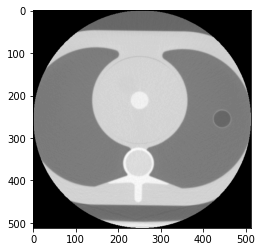

In [158]:
plt.imshow(dcm_array_ori[:,:,10], cmap='gray')

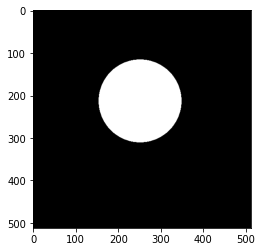

In [159]:
plt.imshow(mask[:,:], cmap='gray')

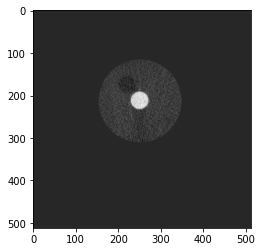

In [160]:
plt.imshow(dcm_array[:,:,10], cmap='gray')

## 2. Segment Calcium Calibration Rod
Segment the large calibration calcium rod insert

In [184]:
calcium_image, CCI_slice, quality_slice, cal_rod_slice, flipped, output = CCI_calcium_image(calcium_threshold=130, comp_connect=4)

idx:  0
idx:  1
idx:  2
idx:  3
idx:  4
idx:  5
idx:  6
idx:  7
idx:  8
index: 1
output[2][index][4] AREA?:  593
output[3][index][1] CENTER-Y:  212
output[3][index][0] CENTER-X:  252
idx:  9
index: 1
output[2][index][4] AREA?:  1362
output[3][index][1] CENTER-Y:  211
output[3][index][0] CENTER-X:  249
idx:  10
index: 1
output[2][index][4] AREA?:  1355
output[3][index][1] CENTER-Y:  211
output[3][index][0] CENTER-X:  249
idx:  11
index: 1
output[2][index][4] AREA?:  1352
output[3][index][1] CENTER-Y:  211
output[3][index][0] CENTER-X:  250
idx:  12
index: 1
output[2][index][4] AREA?:  1333
output[3][index][1] CENTER-Y:  211
output[3][index][0] CENTER-X:  250
idx:  13
index: 1
output[2][index][4] AREA?:  1325
output[3][index][1] CENTER-Y:  211
output[3][index][0] CENTER-X:  249
idx:  14
index: 1
output[2][index][4] AREA?:  1329
output[3][index][1] CENTER-Y:  212
output[3][index][0] CENTER-X:  250
idx:  15
index: 1
output[2][index][4] AREA?:  1306
output[3][index][1] CENTER-Y:  212
output

In [162]:
output

(1,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 array([[     0,      0,    512,    512, 262144]], dtype=int32),
 array([[255.5, 255.5]]))

In [163]:
output[2][0][4]

262144

In [164]:
len(output)

4

In [165]:
output[1].shape

(512, 512)

In [166]:
output[2].shape

(1, 5)

In [167]:
output[3].shape

(1, 2)

In [168]:
np.unique(output[2])

array([     0,    512, 262144], dtype=int32)

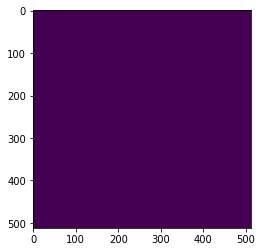

In [169]:
plt.imshow(output[1])

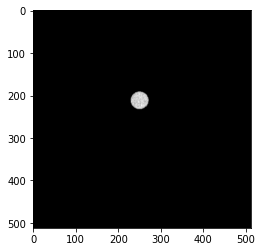

In [170]:
plt.imshow(calcium_image[:,:,10], cmap='gray')

## Segment Inserts
Segment the 9 inserts

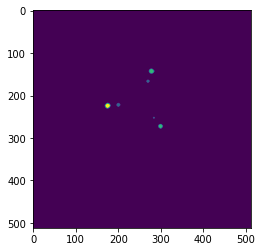

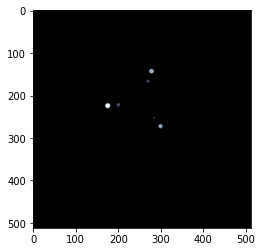

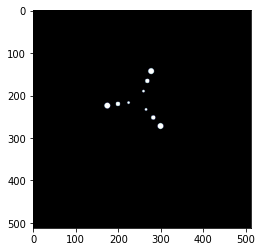

In [171]:
mask1, mask2, mask3, mask4, mask5, mask6, mask7, mask8, mask9 = mask_inserts(True)